# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [12]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: foward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [13]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769847728806635e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [20]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [23]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 5e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

out is : [[0.         0.         0.         0.        ]
 [0.         0.         0.04545455 0.13636364]
 [0.22727273 0.31818182 0.40909091 0.5       ]]
Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [30]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 3e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [31]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  6.750562121603446e-11
dw error:  8.162015570444288e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

You can make sure that the implementations are correct by running the following:

In [32]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [45]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.52e-08
W2 relative error: 3.48e-10
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 8.18e-07
W2 relative error: 2.85e-08
b1 relative error: 1.09e-09
b2 relative error: 7.76e-10


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [61]:
model = TwoLayerNet()
solver = Solver(model, data, update_rule = 'sgd', optim_config = {'learning_rate' : 1e-3,}, lr_decay = 0.9, 
                              batch_size= 100, num_epochs = 30, num_train_samples = 1000, #checkpoint_name = 'solver',
                              print_every = 5, verbose = True)
 

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 14700) loss: 2.302093
(Epoch 0 / 30) train acc: 0.136000; val_acc: 0.146000
(Iteration 6 / 14700) loss: 2.295891
(Iteration 11 / 14700) loss: 2.274493
(Iteration 16 / 14700) loss: 2.241449
(Iteration 21 / 14700) loss: 2.222312
(Iteration 26 / 14700) loss: 2.194786
(Iteration 31 / 14700) loss: 2.139824
(Iteration 36 / 14700) loss: 2.062427
(Iteration 41 / 14700) loss: 2.069075
(Iteration 46 / 14700) loss: 1.989794
(Iteration 51 / 14700) loss: 2.072810
(Iteration 56 / 14700) loss: 1.970642
(Iteration 61 / 14700) loss: 2.047213
(Iteration 66 / 14700) loss: 1.981433
(Iteration 71 / 14700) loss: 1.968906
(Iteration 76 / 14700) loss: 1.869194
(Iteration 81 / 14700) loss: 1.987693
(Iteration 86 / 14700) loss: 1.788685
(Iteration 91 / 14700) loss: 1.813786
(Iteration 96 / 14700) loss: 1.904622
(Iteration 101 / 14700) loss: 1.699015
(Iteration 106 / 14700) loss: 1.805286
(Iteration 111 / 14700) loss: 1.664709
(Iteration 116 / 14700) loss: 1.833874
(Iteration 121 / 14700) loss: 1.

(Iteration 1041 / 14700) loss: 1.548581
(Iteration 1046 / 14700) loss: 1.442387
(Iteration 1051 / 14700) loss: 1.399520
(Iteration 1056 / 14700) loss: 1.325443
(Iteration 1061 / 14700) loss: 1.406266
(Iteration 1066 / 14700) loss: 1.686243
(Iteration 1071 / 14700) loss: 1.500860
(Iteration 1076 / 14700) loss: 1.502584
(Iteration 1081 / 14700) loss: 1.369214
(Iteration 1086 / 14700) loss: 1.555265
(Iteration 1091 / 14700) loss: 1.397643
(Iteration 1096 / 14700) loss: 1.607113
(Iteration 1101 / 14700) loss: 1.218959
(Iteration 1106 / 14700) loss: 1.413886
(Iteration 1111 / 14700) loss: 1.345770
(Iteration 1116 / 14700) loss: 1.402959
(Iteration 1121 / 14700) loss: 1.096646
(Iteration 1126 / 14700) loss: 1.250139
(Iteration 1131 / 14700) loss: 1.337635
(Iteration 1136 / 14700) loss: 1.340966
(Iteration 1141 / 14700) loss: 1.439741
(Iteration 1146 / 14700) loss: 1.371251
(Iteration 1151 / 14700) loss: 1.305232
(Iteration 1156 / 14700) loss: 1.265916
(Iteration 1161 / 14700) loss: 1.410867


(Iteration 2066 / 14700) loss: 1.356969
(Iteration 2071 / 14700) loss: 1.167044
(Iteration 2076 / 14700) loss: 1.330641
(Iteration 2081 / 14700) loss: 1.116586
(Iteration 2086 / 14700) loss: 1.389818
(Iteration 2091 / 14700) loss: 1.438816
(Iteration 2096 / 14700) loss: 1.125429
(Iteration 2101 / 14700) loss: 1.367729
(Iteration 2106 / 14700) loss: 1.265418
(Iteration 2111 / 14700) loss: 1.082938
(Iteration 2116 / 14700) loss: 1.217123
(Iteration 2121 / 14700) loss: 1.330045
(Iteration 2126 / 14700) loss: 1.498728
(Iteration 2131 / 14700) loss: 1.163107
(Iteration 2136 / 14700) loss: 1.252731
(Iteration 2141 / 14700) loss: 1.351563
(Iteration 2146 / 14700) loss: 1.259393
(Iteration 2151 / 14700) loss: 1.362177
(Iteration 2156 / 14700) loss: 1.316902
(Iteration 2161 / 14700) loss: 1.385290
(Iteration 2166 / 14700) loss: 1.350187
(Iteration 2171 / 14700) loss: 1.152739
(Iteration 2176 / 14700) loss: 1.245373
(Iteration 2181 / 14700) loss: 1.303341
(Iteration 2186 / 14700) loss: 1.431252


(Iteration 3091 / 14700) loss: 1.236029
(Iteration 3096 / 14700) loss: 1.123504
(Iteration 3101 / 14700) loss: 1.213674
(Iteration 3106 / 14700) loss: 1.215400
(Iteration 3111 / 14700) loss: 1.222129
(Iteration 3116 / 14700) loss: 1.178258
(Iteration 3121 / 14700) loss: 1.135224
(Iteration 3126 / 14700) loss: 1.261424
(Iteration 3131 / 14700) loss: 1.329181
(Iteration 3136 / 14700) loss: 0.863168
(Iteration 3141 / 14700) loss: 1.180787
(Iteration 3146 / 14700) loss: 1.203966
(Iteration 3151 / 14700) loss: 1.046176
(Iteration 3156 / 14700) loss: 1.232119
(Iteration 3161 / 14700) loss: 1.258780
(Iteration 3166 / 14700) loss: 1.295195
(Iteration 3171 / 14700) loss: 1.186652
(Iteration 3176 / 14700) loss: 1.076815
(Iteration 3181 / 14700) loss: 1.117467
(Iteration 3186 / 14700) loss: 1.125541
(Iteration 3191 / 14700) loss: 1.157496
(Iteration 3196 / 14700) loss: 1.262421
(Iteration 3201 / 14700) loss: 0.962850
(Iteration 3206 / 14700) loss: 1.266372
(Iteration 3211 / 14700) loss: 1.209449


(Iteration 4116 / 14700) loss: 1.221905
(Iteration 4121 / 14700) loss: 1.278653
(Iteration 4126 / 14700) loss: 1.361838
(Iteration 4131 / 14700) loss: 1.152029
(Iteration 4136 / 14700) loss: 1.125687
(Iteration 4141 / 14700) loss: 1.068787
(Iteration 4146 / 14700) loss: 1.453968
(Iteration 4151 / 14700) loss: 1.146465
(Iteration 4156 / 14700) loss: 1.178008
(Iteration 4161 / 14700) loss: 1.279919
(Iteration 4166 / 14700) loss: 1.287137
(Iteration 4171 / 14700) loss: 1.219653
(Iteration 4176 / 14700) loss: 1.360644
(Iteration 4181 / 14700) loss: 1.238305
(Iteration 4186 / 14700) loss: 1.013845
(Iteration 4191 / 14700) loss: 1.337153
(Iteration 4196 / 14700) loss: 0.975984
(Iteration 4201 / 14700) loss: 1.056841
(Iteration 4206 / 14700) loss: 1.140248
(Iteration 4211 / 14700) loss: 1.166353
(Iteration 4216 / 14700) loss: 0.976695
(Iteration 4221 / 14700) loss: 1.022476
(Iteration 4226 / 14700) loss: 1.039298
(Iteration 4231 / 14700) loss: 1.225919
(Iteration 4236 / 14700) loss: 1.247837


(Iteration 5141 / 14700) loss: 1.068560
(Iteration 5146 / 14700) loss: 1.091117
(Iteration 5151 / 14700) loss: 1.065331
(Iteration 5156 / 14700) loss: 0.942032
(Iteration 5161 / 14700) loss: 0.913195
(Iteration 5166 / 14700) loss: 0.897728
(Iteration 5171 / 14700) loss: 1.160183
(Iteration 5176 / 14700) loss: 1.063031
(Iteration 5181 / 14700) loss: 1.070551
(Iteration 5186 / 14700) loss: 1.048397
(Iteration 5191 / 14700) loss: 1.008642
(Iteration 5196 / 14700) loss: 1.018450
(Iteration 5201 / 14700) loss: 1.061437
(Iteration 5206 / 14700) loss: 1.296328
(Iteration 5211 / 14700) loss: 1.282473
(Iteration 5216 / 14700) loss: 0.961628
(Iteration 5221 / 14700) loss: 1.251849
(Iteration 5226 / 14700) loss: 0.979532
(Iteration 5231 / 14700) loss: 0.781814
(Iteration 5236 / 14700) loss: 1.108460
(Iteration 5241 / 14700) loss: 1.045712
(Iteration 5246 / 14700) loss: 1.195184
(Iteration 5251 / 14700) loss: 0.864042
(Iteration 5256 / 14700) loss: 1.062648
(Iteration 5261 / 14700) loss: 1.095125


(Iteration 6166 / 14700) loss: 1.021225
(Iteration 6171 / 14700) loss: 1.150526
(Iteration 6176 / 14700) loss: 0.833979
(Iteration 6181 / 14700) loss: 1.106652
(Iteration 6186 / 14700) loss: 1.057089
(Iteration 6191 / 14700) loss: 0.959384
(Iteration 6196 / 14700) loss: 1.053249
(Iteration 6201 / 14700) loss: 0.908808
(Iteration 6206 / 14700) loss: 0.912484
(Iteration 6211 / 14700) loss: 0.853797
(Iteration 6216 / 14700) loss: 1.134561
(Iteration 6221 / 14700) loss: 0.820285
(Iteration 6226 / 14700) loss: 0.777160
(Iteration 6231 / 14700) loss: 1.090494
(Iteration 6236 / 14700) loss: 1.112564
(Iteration 6241 / 14700) loss: 1.115004
(Iteration 6246 / 14700) loss: 1.003471
(Iteration 6251 / 14700) loss: 0.956116
(Iteration 6256 / 14700) loss: 0.852359
(Iteration 6261 / 14700) loss: 0.974168
(Iteration 6266 / 14700) loss: 0.972934
(Iteration 6271 / 14700) loss: 1.020917
(Iteration 6276 / 14700) loss: 1.248815
(Iteration 6281 / 14700) loss: 0.937851
(Iteration 6286 / 14700) loss: 0.997868


(Iteration 7191 / 14700) loss: 1.058082
(Iteration 7196 / 14700) loss: 0.964299
(Iteration 7201 / 14700) loss: 0.924545
(Iteration 7206 / 14700) loss: 0.840879
(Iteration 7211 / 14700) loss: 0.964097
(Iteration 7216 / 14700) loss: 0.744196
(Iteration 7221 / 14700) loss: 0.988566
(Iteration 7226 / 14700) loss: 0.973782
(Iteration 7231 / 14700) loss: 0.963642
(Iteration 7236 / 14700) loss: 0.903081
(Iteration 7241 / 14700) loss: 1.287864
(Iteration 7246 / 14700) loss: 1.179812
(Iteration 7251 / 14700) loss: 1.077968
(Iteration 7256 / 14700) loss: 1.045334
(Iteration 7261 / 14700) loss: 1.228648
(Iteration 7266 / 14700) loss: 0.927128
(Iteration 7271 / 14700) loss: 1.033351
(Iteration 7276 / 14700) loss: 0.898595
(Iteration 7281 / 14700) loss: 0.886824
(Iteration 7286 / 14700) loss: 0.993691
(Iteration 7291 / 14700) loss: 1.169121
(Iteration 7296 / 14700) loss: 0.953827
(Iteration 7301 / 14700) loss: 1.073060
(Iteration 7306 / 14700) loss: 1.087437
(Iteration 7311 / 14700) loss: 1.048231


(Iteration 8211 / 14700) loss: 1.005666
(Iteration 8216 / 14700) loss: 0.977334
(Iteration 8221 / 14700) loss: 1.053810
(Iteration 8226 / 14700) loss: 0.974617
(Iteration 8231 / 14700) loss: 0.982022
(Iteration 8236 / 14700) loss: 0.787291
(Iteration 8241 / 14700) loss: 0.859508
(Iteration 8246 / 14700) loss: 0.968707
(Iteration 8251 / 14700) loss: 1.002873
(Iteration 8256 / 14700) loss: 1.009995
(Iteration 8261 / 14700) loss: 1.012179
(Iteration 8266 / 14700) loss: 0.903801
(Iteration 8271 / 14700) loss: 0.877688
(Iteration 8276 / 14700) loss: 1.061276
(Iteration 8281 / 14700) loss: 1.009188
(Iteration 8286 / 14700) loss: 0.912494
(Iteration 8291 / 14700) loss: 1.004205
(Iteration 8296 / 14700) loss: 1.028383
(Iteration 8301 / 14700) loss: 0.795846
(Iteration 8306 / 14700) loss: 0.829855
(Iteration 8311 / 14700) loss: 1.136762
(Iteration 8316 / 14700) loss: 1.121851
(Iteration 8321 / 14700) loss: 1.011246
(Iteration 8326 / 14700) loss: 1.059488
(Epoch 17 / 30) train acc: 0.686000; val

(Iteration 9226 / 14700) loss: 1.088724
(Iteration 9231 / 14700) loss: 1.008064
(Iteration 9236 / 14700) loss: 0.869306
(Iteration 9241 / 14700) loss: 1.125166
(Iteration 9246 / 14700) loss: 0.898671
(Iteration 9251 / 14700) loss: 0.720026
(Iteration 9256 / 14700) loss: 0.931518
(Iteration 9261 / 14700) loss: 0.790679
(Iteration 9266 / 14700) loss: 0.966239
(Iteration 9271 / 14700) loss: 0.947958
(Iteration 9276 / 14700) loss: 0.799610
(Iteration 9281 / 14700) loss: 0.807849
(Iteration 9286 / 14700) loss: 0.913873
(Iteration 9291 / 14700) loss: 0.974514
(Iteration 9296 / 14700) loss: 0.686665
(Iteration 9301 / 14700) loss: 0.910313
(Iteration 9306 / 14700) loss: 0.860153
(Epoch 19 / 30) train acc: 0.702000; val_acc: 0.526000
(Iteration 9311 / 14700) loss: 0.826870
(Iteration 9316 / 14700) loss: 0.819797
(Iteration 9321 / 14700) loss: 0.875164
(Iteration 9326 / 14700) loss: 0.952509
(Iteration 9331 / 14700) loss: 0.698685
(Iteration 9336 / 14700) loss: 1.034853
(Iteration 9341 / 14700) 

(Iteration 10236 / 14700) loss: 0.868382
(Iteration 10241 / 14700) loss: 1.061989
(Iteration 10246 / 14700) loss: 1.219257
(Iteration 10251 / 14700) loss: 0.933581
(Iteration 10256 / 14700) loss: 0.865070
(Iteration 10261 / 14700) loss: 1.115009
(Iteration 10266 / 14700) loss: 0.794063
(Iteration 10271 / 14700) loss: 0.968736
(Iteration 10276 / 14700) loss: 0.937545
(Iteration 10281 / 14700) loss: 0.930907
(Iteration 10286 / 14700) loss: 0.901811
(Epoch 21 / 30) train acc: 0.653000; val_acc: 0.524000
(Iteration 10291 / 14700) loss: 0.846085
(Iteration 10296 / 14700) loss: 0.850397
(Iteration 10301 / 14700) loss: 1.102575
(Iteration 10306 / 14700) loss: 0.931036
(Iteration 10311 / 14700) loss: 0.915841
(Iteration 10316 / 14700) loss: 0.861211
(Iteration 10321 / 14700) loss: 0.902946
(Iteration 10326 / 14700) loss: 1.014925
(Iteration 10331 / 14700) loss: 0.765105
(Iteration 10336 / 14700) loss: 1.003522
(Iteration 10341 / 14700) loss: 1.053700
(Iteration 10346 / 14700) loss: 0.958428
(I

(Iteration 11236 / 14700) loss: 0.887564
(Iteration 11241 / 14700) loss: 0.877915
(Iteration 11246 / 14700) loss: 0.957462
(Iteration 11251 / 14700) loss: 1.005250
(Iteration 11256 / 14700) loss: 0.973343
(Iteration 11261 / 14700) loss: 1.036942
(Iteration 11266 / 14700) loss: 1.021459
(Epoch 23 / 30) train acc: 0.707000; val_acc: 0.532000
(Iteration 11271 / 14700) loss: 0.871181
(Iteration 11276 / 14700) loss: 0.690675
(Iteration 11281 / 14700) loss: 1.002802
(Iteration 11286 / 14700) loss: 0.879324
(Iteration 11291 / 14700) loss: 0.798084
(Iteration 11296 / 14700) loss: 0.977250
(Iteration 11301 / 14700) loss: 0.876100
(Iteration 11306 / 14700) loss: 0.850815
(Iteration 11311 / 14700) loss: 1.082826
(Iteration 11316 / 14700) loss: 0.804894
(Iteration 11321 / 14700) loss: 0.867539
(Iteration 11326 / 14700) loss: 0.755941
(Iteration 11331 / 14700) loss: 0.881810
(Iteration 11336 / 14700) loss: 0.845412
(Iteration 11341 / 14700) loss: 1.093210
(Iteration 11346 / 14700) loss: 0.795742
(I

(Iteration 12236 / 14700) loss: 0.876554
(Iteration 12241 / 14700) loss: 0.718521
(Iteration 12246 / 14700) loss: 0.746056
(Epoch 25 / 30) train acc: 0.693000; val_acc: 0.518000
(Iteration 12251 / 14700) loss: 0.812329
(Iteration 12256 / 14700) loss: 0.885130
(Iteration 12261 / 14700) loss: 0.892420
(Iteration 12266 / 14700) loss: 0.919481
(Iteration 12271 / 14700) loss: 0.909807
(Iteration 12276 / 14700) loss: 0.896229
(Iteration 12281 / 14700) loss: 1.039105
(Iteration 12286 / 14700) loss: 1.038839
(Iteration 12291 / 14700) loss: 0.771542
(Iteration 12296 / 14700) loss: 0.821460
(Iteration 12301 / 14700) loss: 0.898479
(Iteration 12306 / 14700) loss: 0.785493
(Iteration 12311 / 14700) loss: 0.921847
(Iteration 12316 / 14700) loss: 0.849706
(Iteration 12321 / 14700) loss: 0.945375
(Iteration 12326 / 14700) loss: 1.021414
(Iteration 12331 / 14700) loss: 0.732017
(Iteration 12336 / 14700) loss: 0.985876
(Iteration 12341 / 14700) loss: 0.883772
(Iteration 12346 / 14700) loss: 0.968964
(I

(Iteration 13236 / 14700) loss: 0.657222
(Iteration 13241 / 14700) loss: 0.957736
(Iteration 13246 / 14700) loss: 0.821413
(Iteration 13251 / 14700) loss: 1.037204
(Iteration 13256 / 14700) loss: 0.891177
(Iteration 13261 / 14700) loss: 0.912366
(Iteration 13266 / 14700) loss: 0.850365
(Iteration 13271 / 14700) loss: 0.783624
(Iteration 13276 / 14700) loss: 0.940305
(Iteration 13281 / 14700) loss: 0.963250
(Iteration 13286 / 14700) loss: 0.937014
(Iteration 13291 / 14700) loss: 0.969807
(Iteration 13296 / 14700) loss: 0.903680
(Iteration 13301 / 14700) loss: 0.935189
(Iteration 13306 / 14700) loss: 0.736913
(Iteration 13311 / 14700) loss: 0.811843
(Iteration 13316 / 14700) loss: 0.973640
(Iteration 13321 / 14700) loss: 0.808377
(Iteration 13326 / 14700) loss: 0.775910
(Iteration 13331 / 14700) loss: 0.943615
(Iteration 13336 / 14700) loss: 0.997035
(Iteration 13341 / 14700) loss: 0.860106
(Iteration 13346 / 14700) loss: 0.995467
(Iteration 13351 / 14700) loss: 0.837682
(Iteration 13356

(Iteration 14226 / 14700) loss: 0.888337
(Iteration 14231 / 14700) loss: 0.822091
(Iteration 14236 / 14700) loss: 0.758827
(Iteration 14241 / 14700) loss: 0.753382
(Iteration 14246 / 14700) loss: 0.959233
(Iteration 14251 / 14700) loss: 0.819046
(Iteration 14256 / 14700) loss: 0.885611
(Iteration 14261 / 14700) loss: 0.859299
(Iteration 14266 / 14700) loss: 0.898272
(Iteration 14271 / 14700) loss: 1.102354
(Iteration 14276 / 14700) loss: 0.734956
(Iteration 14281 / 14700) loss: 0.899403
(Iteration 14286 / 14700) loss: 0.914599
(Iteration 14291 / 14700) loss: 0.937090
(Iteration 14296 / 14700) loss: 0.910480
(Iteration 14301 / 14700) loss: 1.082003
(Iteration 14306 / 14700) loss: 0.810375
(Iteration 14311 / 14700) loss: 0.710717
(Iteration 14316 / 14700) loss: 1.043118
(Iteration 14321 / 14700) loss: 1.148075
(Iteration 14326 / 14700) loss: 1.110131
(Iteration 14331 / 14700) loss: 0.977492
(Iteration 14336 / 14700) loss: 0.876332
(Iteration 14341 / 14700) loss: 0.918056
(Iteration 14346

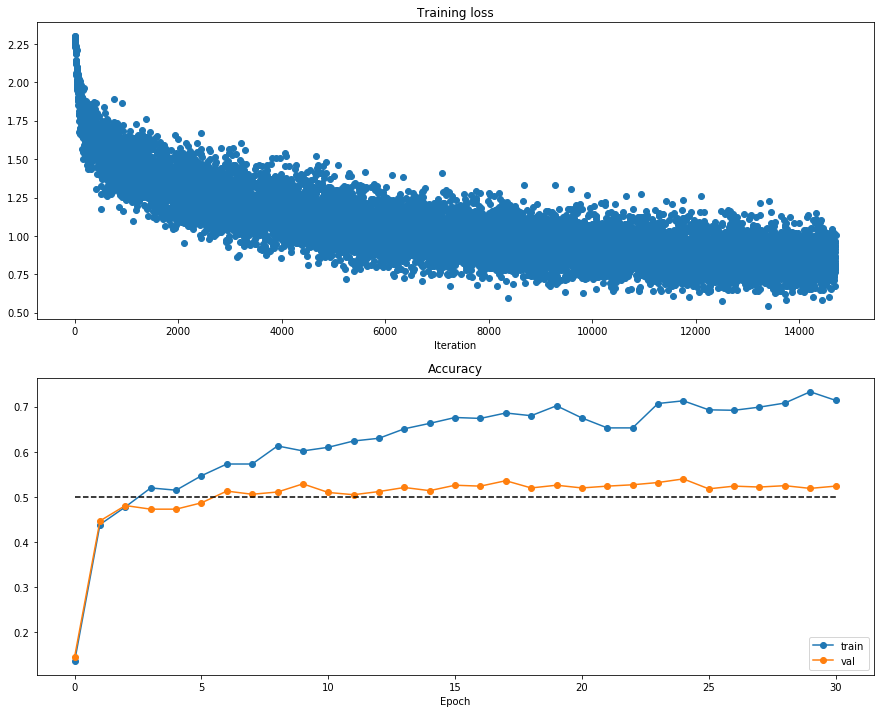

In [62]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [87]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  3.7636484472792726
W1 relative error: 2.12e-08
W2 relative error: 8.39e-07
W3 relative error: 3.71e-08
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  3.814535655506903
W1 relative error: 3.16e-08
W2 relative error: 7.65e-08
W3 relative error: 6.81e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 18.169867
(Epoch 0 / 20) train acc: 0.280000; val_acc: 0.143000
(Epoch 1 / 20) train acc: 0.440000; val_acc: 0.135000
(Epoch 2 / 20) train acc: 0.440000; val_acc: 0.155000
(Epoch 3 / 20) train acc: 0.440000; val_acc: 0.114000
(Epoch 4 / 20) train acc: 0.680000; val_acc: 0.171000
(Epoch 5 / 20) train acc: 0.780000; val_acc: 0.192000
(Iteration 11 / 40) loss: 14.485626
(Epoch 6 / 20) train acc: 0.680000; val_acc: 0.149000
(Epoch 7 / 20) train acc: 0.780000; val_acc: 0.184000
(Epoch 8 / 20) train acc: 0.820000; val_acc: 0.188000
(Epoch 9 / 20) train acc: 0.820000; val_acc: 0.168000
(Epoch 10 / 20) train acc: 0.880000; val_acc: 0.190000
(Iteration 21 / 40) loss: 11.536816
(Epoch 11 / 20) train acc: 0.860000; val_acc: 0.192000
(Epoch 12 / 20) train acc: 0.940000; val_acc: 0.186000
(Epoch 13 / 20) train acc: 0.940000; val_acc: 0.194000
(Epoch 14 / 20) train acc: 0.960000; val_acc: 0.173000
(Epoch 15 / 20) train acc: 0.980000; val_acc: 0.206000
(Iteration 31 / 40) los

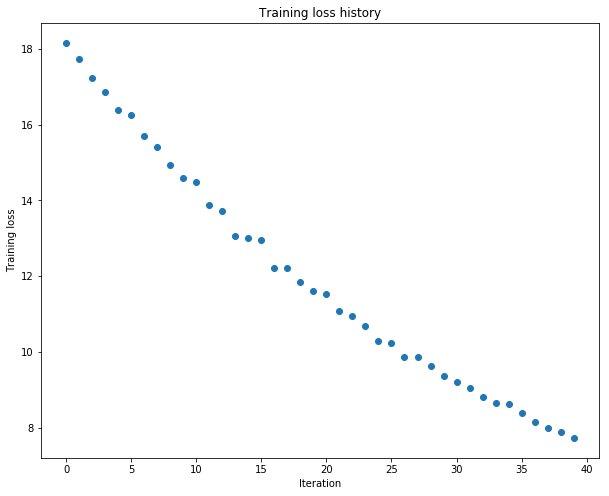

In [92]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2
learning_rate = 1e-2
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 427.267055
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.115000
(Epoch 1 / 20) train acc: 0.260000; val_acc: 0.131000
(Epoch 2 / 20) train acc: 0.600000; val_acc: 0.126000
(Epoch 3 / 20) train acc: 0.820000; val_acc: 0.152000
(Epoch 4 / 20) train acc: 0.880000; val_acc: 0.149000
(Epoch 5 / 20) train acc: 0.960000; val_acc: 0.146000
(Iteration 11 / 40) loss: 346.998474
(Epoch 6 / 20) train acc: 0.960000; val_acc: 0.137000
(Epoch 7 / 20) train acc: 0.960000; val_acc: 0.156000
(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.146000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.152000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.152000
(Iteration 21 / 40) loss: 284.050292
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.146000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.164000
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.176000
(Epoch 14 / 20) train acc: 0.980000; val_acc: 0.156000
(Epoch 15 / 20) train acc: 0.980000; val_acc: 0.152000
(Iteration 31 / 40) 

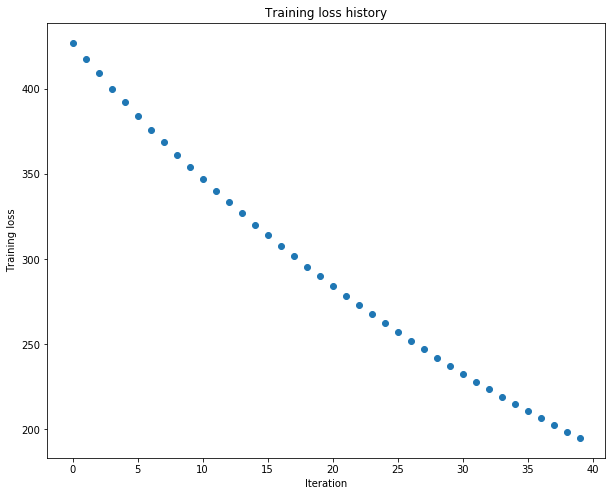

In [110]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}
learning_rate = 1e-2
weight_scale = 5e-2


model = FullyConnectedNet([100, 100, 100, 100],
                        weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                        print_every=10, num_epochs=20, batch_size=25,
                        update_rule='sgd',
                        optim_config={
                          'learning_rate': learning_rate,
                        }
                 )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

# Answer:
[Three-layer net is more easier to train. If loss is lower it directly result in good train accuracy.
 However, five layer net is more tricky to train. Small loss doesn't directly connect to it's train accuracy is high. There must be something behind this. So, There are more layers in 5 layers than 3 layers network. Since we initializaed all the weight parameters with small values, the values of output will significantly shrink whenever they pass each layer. So, it is more sensive to the initial weight parameter's scale. It should be reasonabley 'big' in order to not make dead parameters.. ]


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [7]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 200) loss: 438.423285
(Epoch 0 / 5) train acc: 0.108000; val_acc: 0.108000
(Iteration 11 / 200) loss: 358.557344
(Iteration 21 / 200) loss: 293.673979
(Iteration 31 / 200) loss: 240.659668
(Epoch 1 / 5) train acc: 0.240000; val_acc: 0.209000
(Iteration 41 / 200) loss: 197.278132
(Iteration 51 / 200) loss: 161.804145
(Iteration 61 / 200) loss: 132.782033
(Iteration 71 / 200) loss: 109.046543
(Epoch 2 / 5) train acc: 0.209000; val_acc: 0.196000
(Iteration 81 / 200) loss: 89.625763
(Iteration 91 / 200) loss: 73.736794
(Iteration 101 / 200) loss: 60.736144
(Iteration 111 / 200) loss: 50.098116
(Epoch 3 / 5) train acc: 0.217000; val_acc: 0.181000
(Iteration 121 / 200) loss: 41.398021
(Iteration 131 / 200) loss: 34.280200
(Iteration 141 / 200) loss: 28.456417
(Iteration 151 / 200) loss: 23.696084
(Epoch 4 / 5) train acc: 0.116000; val_acc: 0.078000
(Iteration 161 / 200) loss: 19.799397
(Iteration 171 / 200) loss: 16.614175
(Iteration 181 / 200) loss: 14.00917

C:\Users\HyunwooJo\Anaconda3\envs\base2\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


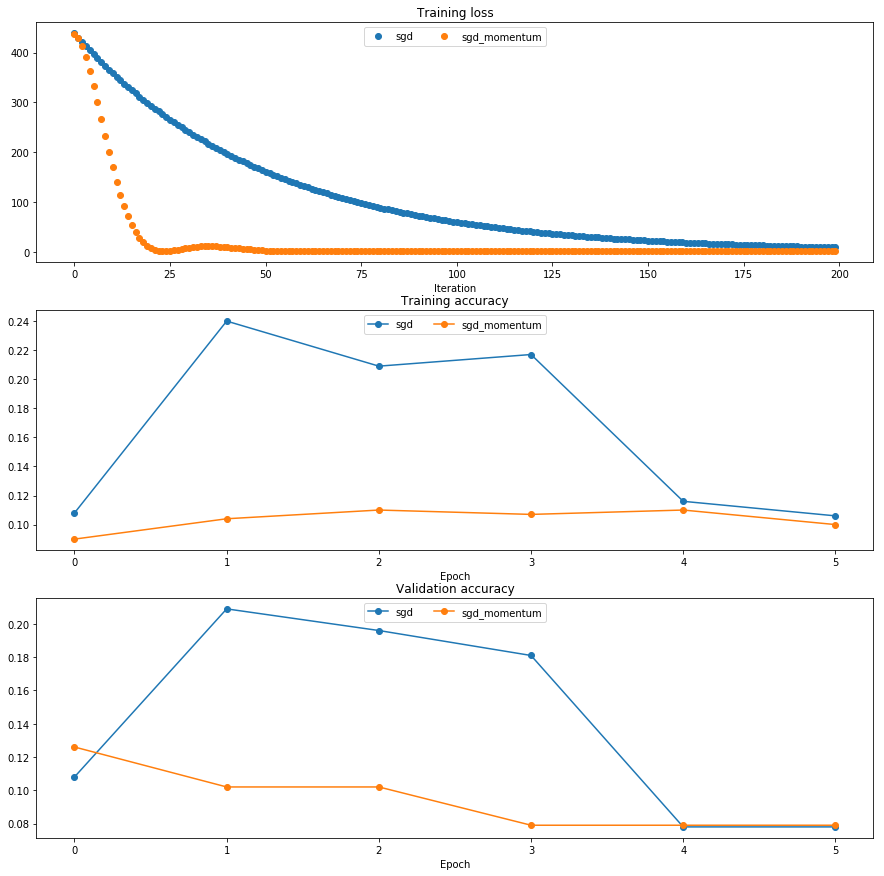

In [15]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [19]:
# Test RMSProp implementation; you should see errors less than 1e-7
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.502645229894295e-08
cache error:  2.6477955807156126e-09


In [39]:
# Test Adam implementation; you e see errors around 1e-7 or less
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

running with  adam
(Iteration 1 / 200) loss: 437.896622
(Epoch 0 / 5) train acc: 0.144000; val_acc: 0.125000
(Iteration 11 / 200) loss: 324.076664
(Iteration 21 / 200) loss: 232.085080
(Iteration 31 / 200) loss: 165.461944
(Epoch 1 / 5) train acc: 0.216000; val_acc: 0.207000
(Iteration 41 / 200) loss: 118.273370
(Iteration 51 / 200) loss: 84.996393
(Iteration 61 / 200) loss: 61.522702
(Iteration 71 / 200) loss: 44.881957
(Epoch 2 / 5) train acc: 0.145000; val_acc: 0.143000
(Iteration 81 / 200) loss: 33.029480
(Iteration 91 / 200) loss: 24.541211
(Iteration 101 / 200) loss: 18.441036
(Iteration 111 / 200) loss: 14.041078
(Epoch 3 / 5) train acc: 0.106000; val_acc: 0.079000
(Iteration 121 / 200) loss: 10.855482
(Iteration 131 / 200) loss: 8.546950
(Iteration 141 / 200) loss: 6.866847
(Iteration 151 / 200) loss: 5.641584
(Epoch 4 / 5) train acc: 0.104000; val_acc: 0.079000
(Iteration 161 / 200) loss: 4.751992
(Iteration 171 / 200) loss: 4.099561
(Iteration 181 / 200) loss: 3.621475
(Itera

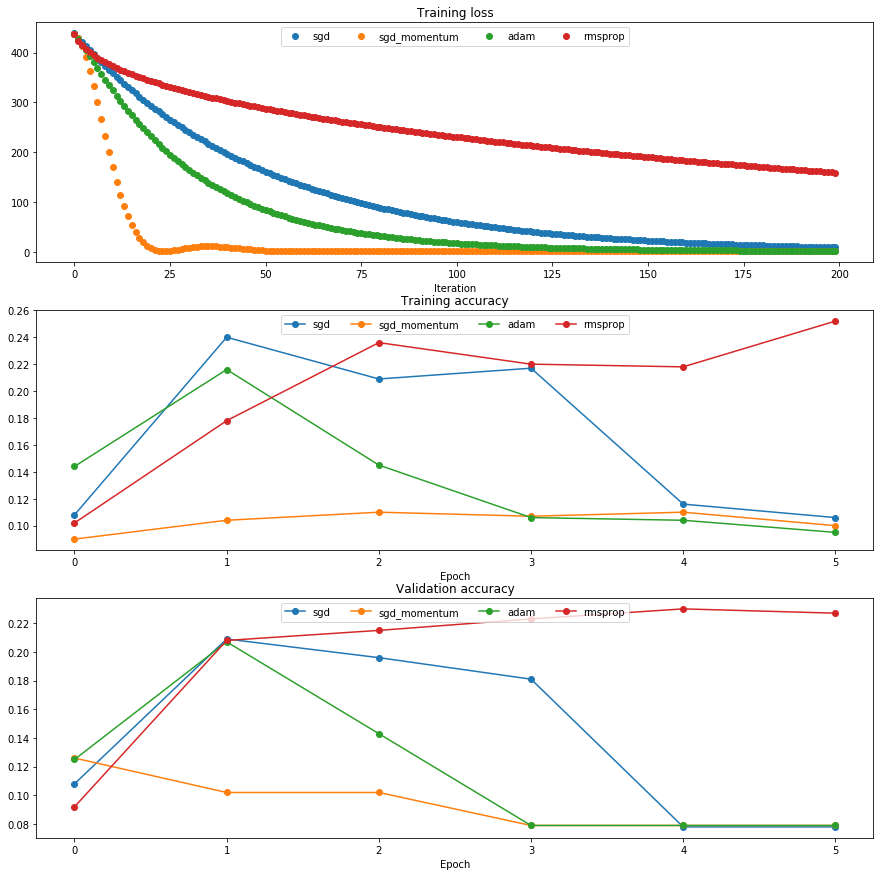

In [41]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [45]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################
model = FullyConnectedNet([500,500,500,500],weight_scale = 1e-3)
solver = Solver(model, data, update_rule = 'adam', optim_config = {'learning_rate' : 1e-3}, lr_decay = 0.95,
               num_epochs = 20, batch_size = 100, print_every = 100)
solver.train()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 9800) loss: 2.302585
(Epoch 0 / 20) train acc: 0.102000; val_acc: 0.119000
(Iteration 101 / 9800) loss: 2.097249
(Iteration 201 / 9800) loss: 2.016832
(Iteration 301 / 9800) loss: 1.729996
(Iteration 401 / 9800) loss: 1.806296
(Epoch 1 / 20) train acc: 0.405000; val_acc: 0.389000
(Iteration 501 / 9800) loss: 1.682612
(Iteration 601 / 9800) loss: 1.640020
(Iteration 701 / 9800) loss: 1.688377
(Iteration 801 / 9800) loss: 1.613480
(Iteration 901 / 9800) loss: 1.628711
(Epoch 2 / 20) train acc: 0.472000; val_acc: 0.441000
(Iteration 1001 / 9800) loss: 1.662766
(Iteration 1101 / 9800) loss: 1.575918
(Iteration 1201 / 9800) loss: 1.374908
(Iteration 1301 / 9800) loss: 1.395552
(Iteration 1401 / 9800) loss: 1.296942
(Epoch 3 / 20) train acc: 0.512000; val_acc: 0.472000
(Iteration 1501 / 9800) loss: 1.590595
(Iteration 1601 / 9800) loss: 1.220264
(Iteration 1701 / 9800) loss: 1.316998
(Iteration 1801 / 9800) loss: 1.338791
(Iteration 1901 / 9800) loss: 1.330360
(Epoch 4 / 20) t

# Test you model
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())